In [29]:
import numpy as np
import pandas as pd
from collections import defaultdict, OrderedDict
import glob
import sys, os
sys.path.append('..')
sys.path.append('../../../../utils')
sys.path.append('../../../../third')
import pandas as pd
from plotly.graph_objs import Scatter,Layout
import plotly
import plotly.graph_objs as go
import plotly.offline as py
import plotly.figure_factory as ff
import gezi
from gezi import tqdm
from absl import flags
FLAGS = flags.FLAGS

In [2]:
FLAGS([''])

['']

In [3]:
valid_file = '../input/valid.csv'
with gezi.Timer('read_valid', print_fn=ic):
  df_truth = pd.read_csv('../input/valid.csv')
  df_truth = df_truth.sort_values(['userid', 'feedid'])

ic| '%s start' % self.info: 'read_valid start'
ic| '{} duration: {}'.format(self.info, self.elapsed()): 'read_valid duration: 11.29423475265503'


In [4]:
files_ = [('../working/offline//21/mid.todays/valid.csv', 1.0),
                                ('../working/offline//21/mid.merge/valid.csv', 1.0),
                                ('../working/offline//21/mid.share/valid.csv', 1.0),
                                ('../working/offline//21/big/valid.csv', 1.0),
                                ('../working/offline//21/large/valid.csv', 1.0),
                                ('../working/offline//21/mid.doc2/valid.csv', 1.0),
                                ('../working/offline//21/mid.user/valid.csv', 1.0),
                                ('../working/offline//21/mid.day/valid.csv', 1.0),
                                ('../working/offline//21/mid.feeddocfreeze/valid.csv', 1.0),
                                ('../working/offline//21/large.docfreeze/valid.csv', 1.0),
                                ('../working/offline//21/large.docfreeze.day/valid.csv', 1.0)]

In [30]:
files = [x[0] for x in files_]
weights = [x[1] for x in files_]
models = [os.path.basename(os.path.dirname(x)) for x in files]

In [6]:
from wechat.util import ensemble
from wechat.eval import evaluate
from wechat.config import ACTIONS

In [7]:
FLAGS.action_list = ACTIONS
dfs = []
for i in tqdm(range(len(files))):
  df_pred = pd.read_csv(files[i])
  df_pred = df_pred.sort_values(['userid', 'feedid'])
  dfs.append(df_pred)

100%|██████████| 11/11 [14:16<00:00, 77.90s/it] 


In [11]:
# with gezi.Timer('ensemble', print_fn=ic):
#   df_pred = ensemble(dfs, weights)

# preds = []
# for action in ACTIONS:
#   preds.append(df_pred[action].values)
  
# preds = np.stack(preds, 1)
# x = {}
# for col in df_truth.columns:
#   x[col] = df_truth[col].values
# res = evaluate(None, preds, x, from_logits=False)
# res = gezi.dict_rename(res, 'Metrics/', '')
# gezi.pprint_dict(res)

In [9]:
nf = len(files)
sim_mat = np.zeros([nf, nf])
sim_mat

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [17]:
def diff_models(x, y, action='read_comment'):
  diff = gezi.metrics.inverse_ratio(x[action].values, y[action].values)
  return diff

In [11]:
for i in tqdm(range(nf)):
  for j in range(nf):
    if j > i:
      sim_mat[i][j] = diff_models(dfs[i], dfs[j])

100%|██████████| 11/11 [03:28<00:00, 18.96s/it]


In [24]:
for i in range(nf):
  for j in range(nf):
    if j < i:
        sim_mat[i][j] = sim_mat[j][i]

In [62]:
print(models[0], models[1])

mid.todays mid.merge


In [61]:
sim_mat[0][1]

0.0688449608079513

In [13]:
# sim_mat

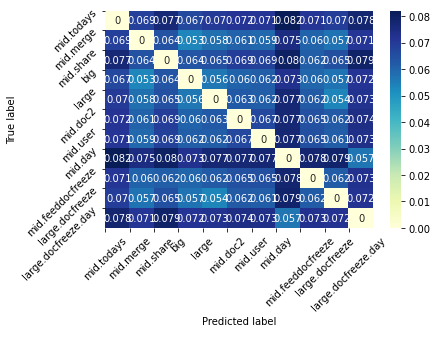

In [31]:
x = gezi.plot.confusion_matrix(sim_mat, models)

In [28]:
heat = go.Heatmap(z=sim_mat,
              x=[os.path.basename(os.path.dirname(x)) for x in files],
              y=[os.path.basename(os.path.dirname(x)) for x in files],
              xgap=1, ygap=1,
              )
layout = go.Layout(
width=1000, height=1000,
xaxis_showgrid=False,
yaxis_showgrid=False,
yaxis_autorange='reversed',
)
fig=go.Figure(data=[heat], layout=layout)
fig.update_xaxes(tickangle=-45)
# fig.update_yaxes(tickangle=-45)
# py.iplot(fig)
html_file = 'debug.html'
fig.write_html(html_file, auto_open=True)

In [63]:
def plot(sim_mat, action='read_comment'):
  annotation_text = np.empty(sim_mat.shape)
  for i in range(len(sim_mat)):
    for j in range(len(sim_mat)):
      annotation_text[i][j] = str(round(sim_mat[i][j], 3))
  fig = ff.create_annotated_heatmap(z=sim_mat, x=models, y=models, annotation_text=annotation_text, colorscale='Viridis')
  # fig = ff.create_annotated_heatmap(z=sim_mat, x=models, y=models)
  # add title
  fig.update_layout(title_text=f'<i><b>ReverseRatio of Models on {action}</b></i>',
#                     yaxis_autorange='reversed',
                    xaxis={'side': 'bottom'}, 
                   )

  # add colorbar
  fig['data'][0]['showscale'] = True
  # fig.show()
  html_file = 'debug.html'
  fig.write_html(html_file, auto_open=True)

In [64]:
plot(sim_mat)

In [15]:
nf = len(files)
sim_mat2 = np.zeros([nf, nf])
# sim_mat2

In [18]:
for i in tqdm(range(nf)):
  for j in range(nf):
    if j > i:
      sim_mat2[i][j] = diff_models(dfs[i], dfs[j], 'favorite')

100%|██████████| 11/11 [03:45<00:00, 20.53s/it]


In [59]:
for i in range(nf):
  for j in range(nf):
    if j < i:
        sim_mat2[i][j] = sim_mat2[j][i]

In [65]:
plot(sim_mat2, 'favorite')